In [15]:
import pandas as pd
from music21 import converter, note, stream, chord
import itertools
import warnings
import random
import numpy as np
import ast
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import ast
import matplotlib.pyplot as plt
from collections import Counter
import joblib

warnings.filterwarnings("ignore")

In [16]:
#import de la table
path = '..\data\maestro-v3.0.0.csv'
df = pd.read_csv(path)

In [17]:
dfs = df.groupby('canonical_composer', group_keys=False).apply(lambda x: x.sample(frac=0.1, random_state=42))

In [18]:
def extraction_notes(file):
    '''
    Fonction pour extraires les notes d'un fichiers midi dans une liste
    avec les éléments int compris entre 0 et 127 
    Pour les accords on ne prend que la note la plus haute (la plus aigue)
    '''
    midi = converter.parse(file)
    L_notes = []
    for e in midi.recurse().notes:
        if e.isNote:
            N = e.pitch.midi
            L_notes.append(N)
        elif e.isChord:
            accords = [n.midi for n in e.pitches]
            N = max(accords)
            L_notes.append(N)
    if len(L_notes)<50:
        return 'null'
    else:
        return L_notes 
    
def ex_notes_tab(df,col_out):
    '''
    Création de la colonne contenant la liste des notes
    '''
    df['midi_file_data'] = '../data/'+df['midi_filename']
    df[col_out] = df['midi_file_data'].apply(extraction_notes)
    return df[df[col_out]!='null']

def sequence_list(L):
    ''' création des séquences de 50 notes et output cette liste et de la note suivante (cible)'''
    sequence_length = 50

    input_sequences = []
    output_notes = []

    for i in range(len(L) - sequence_length):
        seq_in = L[i:i + sequence_length]  
        seq_out = L[i + sequence_length]  
        input_sequences.append(seq_in)
        output_notes.append(seq_out)

    return input_sequences,output_notes

def sequence(dff):
    ''' 
    Application du séquencage à toutes les musiques
    '''
    X,y = [],[]
    for k in dff['notes'].to_list():
        xtemp,ytemp = sequence_list(k)
        X.append(xtemp)
        y.append(ytemp)
    X=list(itertools.chain(*X))
    y=list(itertools.chain(*y))

    return pd.DataFrame({"X":X,"y":y})

def colonnes(df):
    ''' mise en forme : 1 temps = 1 colonne = 1 note '''
    df_expanded = df['X'].apply(pd.Series)
    df_expanded['y'] = df['y']
    return df_expanded

In [19]:
dfs = colonnes(sequence(ex_notes_tab(dfs,'notes')))

i=0
L_retenu = []
while i<dfs.shape[0]:
    if (i==0) or (i%10==0):
        L_retenu.append(i)
    i+=1

dfs2 = dfs[dfs.index.isin(L_retenu)]
dfs2


,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,y
0,45,44,42,40,42,42,42,42,42,42,...,66,70,66,80,75,90,68,87,80,87
10,40,33,51,42,40,42,42,42,42,40,...,70,80,90,58,68,75,70,80,87,90
20,46,51,42,42,40,51,40,56,63,40,...,58,68,75,87,70,66,80,90,75,83
30,68,69,75,69,82,92,96,106,80,89,...,70,66,80,75,83,74,85,88,70,80
40,70,66,70,66,80,75,90,68,87,80,...,80,84,86,92,72,92,70,80,92,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375820,75,79,74,84,71,55,55,55,55,60,...,84,88,84,81,79,55,78,53,77,76
375830,78,55,76,76,77,74,79,52,52,52,...,74,77,77,76,74,76,74,74,60,71
375840,52,57,75,59,66,76,72,78,48,48,...,67,66,65,64,74,74,76,62,57,65
375850,48,48,53,71,72,53,69,81,79,74,...,55,64,64,62,62,60,65,64,67,62


In [20]:
def def_octave(x):
    return x//12

def def_note(x):
    return x%12

In [21]:
df_train, df_temp = train_test_split(dfs2, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

dfn_train,dfo_train = df_train.copy(),df_train.copy()
dfn_val,dfo_val = df_val.copy(),df_val.copy()
dfn_test,dfo_test = df_test.copy(),df_test.copy()

for k in df_train:
    dfn_train[k] = dfn_train[k].apply(def_note)
    dfn_val[k] = dfn_val[k].apply(def_note)
    dfn_test[k] = dfn_test[k].apply(def_note)

    dfo_train[k] = dfo_train[k].apply(def_octave)
    dfo_val[k] = dfo_val[k].apply(def_octave)
    dfo_test[k] = dfo_test[k].apply(def_octave)

In [22]:
def df_to_tensor(df,num_classes):
    ''' mise en forme sous tenseurs avec les notes en tant que catégories '''
    col = [i for i in df.columns if i!='y']
    X_raw = df[col].values.astype(int)
    X = to_categorical(X_raw, num_classes=num_classes)
    y_raw = df["y"].astype(int).values
    y = to_categorical(y_raw, num_classes=num_classes)
    return X, y

nb_octave = 11
nb_note = 13

Xo_train, yo_train = df_to_tensor(pd.DataFrame(dfo_train),11)
Xo_val, yo_val = df_to_tensor(pd.DataFrame(dfo_val),11)
Xo_test, yo_test = df_to_tensor(pd.DataFrame(dfo_test),11)

Xn_train, yn_train = df_to_tensor(pd.DataFrame(dfn_train),13)
Xn_val, yn_val = df_to_tensor(pd.DataFrame(dfn_val),13)
Xn_test, yn_test = df_to_tensor(pd.DataFrame(dfn_test),13)


In [23]:
sequence_length = 50

modelo = Sequential()
modelo.add(LSTM(256, input_shape=(sequence_length, nb_octave), return_sequences=True))
modelo.add(Dropout(0.3))
modelo.add(LSTM(256))
modelo.add(Dropout(0.3))
modelo.add(Dense(nb_octave))
modelo.add(Activation('softmax'))

optimizer = RMSprop(learning_rate=0.001)
modelo.compile(loss='categorical_crossentropy', optimizer=optimizer)

historyo = modelo.fit(
    Xo_train, yo_train,
    validation_data=(Xo_val, yo_val),
    epochs=100,
    batch_size=32
)

Epoch 1/100
823/823 ━━━━━━━━━━━━━━━━━━━━ 53s 62ms/step - loss: 1.3978 - val_loss: 1.2664
Epoch 2/100
823/823 ━━━━━━━━━━━━━━━━━━━━ 60s 73ms/step - loss: 1.2611 - val_loss: 1.2637
Epoch 3/100
823/823 ━━━━━━━━━━━━━━━━━━━━ 58s 70ms/step - loss: 1.2509 - val_loss: 1.2535
Epoch 4/100
823/823 ━━━━━━━━━━━━━━━━━━━━ 57s 69ms/step - loss: 1.2421 - val_loss: 1.2566
Epoch 5/100
823/823 ━━━━━━━━━━━━━━━━━━━━ 57s 69ms/step - loss: 1.2383 - val_loss: 1.2422
Epoch 6/100
823/823 ━━━━━━━━━━━━━━━━━━━━ 58s 71ms/step - loss: 1.2248 - val_loss: 1.2400
Epoch 7/100
823/823 ━━━━━━━━━━━━━━━━━━━━ 65s 79ms/step - loss: 1.2235 - val_loss: 1.2402
Epoch 8/100
823/823 ━━━━━━━━━━━━━━━━━━━━ 60s 72ms/step - loss: 1.2224 - val_loss: 1.2403
Epoch 9/100
823/823 ━━━━━━━━━━━━━━━━━━━━ 61s 74ms/step - loss: 1.2335 - val_loss: 1.2374
Epoch 10/100
823/823 ━━━━━━━━━━━━━━━━━━━━ 64s 77ms/step - loss: 1.2257 - val_loss: 1.2382
Epoch 11/100
823/823 ━━━━━━━━━━━━━━━━━━━━ 60s 72ms/step - loss: 1.2149 - val_loss: 1.2352
Epoch 12/100
823/82

In [24]:
modeln = Sequential()
modeln.add(LSTM(256, input_shape=(sequence_length, nb_note), return_sequences=True))
modeln.add(Dropout(0.3))
modeln.add(LSTM(256))
modeln.add(Dropout(0.3))
modeln.add(Dense(nb_note))
modeln.add(Activation('softmax'))

optimizer = RMSprop(learning_rate=0.001)
modeln.compile(loss='categorical_crossentropy', optimizer=optimizer)

historyn = modeln.fit(
    Xn_train, yn_train,
    validation_data=(Xn_val, yn_val),
    epochs=200,
    batch_size=32
)

Epoch 1/200
823/823 ━━━━━━━━━━━━━━━━━━━━ 66s 78ms/step - loss: 2.3286 - val_loss: 2.2260
Epoch 2/200
823/823 ━━━━━━━━━━━━━━━━━━━━ 61s 74ms/step - loss: 2.2305 - val_loss: 2.2220
Epoch 3/200
823/823 ━━━━━━━━━━━━━━━━━━━━ 61s 74ms/step - loss: 2.2095 - val_loss: 2.2148
Epoch 4/200
823/823 ━━━━━━━━━━━━━━━━━━━━ 61s 74ms/step - loss: 2.1992 - val_loss: 2.2105
Epoch 5/200
823/823 ━━━━━━━━━━━━━━━━━━━━ 60s 73ms/step - loss: 2.1799 - val_loss: 2.1829
Epoch 6/200
823/823 ━━━━━━━━━━━━━━━━━━━━ 60s 73ms/step - loss: 2.1818 - val_loss: 2.1748
Epoch 7/200
823/823 ━━━━━━━━━━━━━━━━━━━━ 60s 73ms/step - loss: 2.1799 - val_loss: 2.1842
Epoch 8/200
823/823 ━━━━━━━━━━━━━━━━━━━━ 61s 74ms/step - loss: 2.1652 - val_loss: 2.1817
Epoch 9/200
823/823 ━━━━━━━━━━━━━━━━━━━━ 63s 76ms/step - loss: 2.1583 - val_loss: 2.1636
Epoch 10/200
823/823 ━━━━━━━━━━━━━━━━━━━━ 60s 73ms/step - loss: 2.1505 - val_loss: 2.1576
Epoch 11/200
823/823 ━━━━━━━━━━━━━━━━━━━━ 57s 69ms/step - loss: 2.1366 - val_loss: 2.1667
Epoch 12/200
823/82

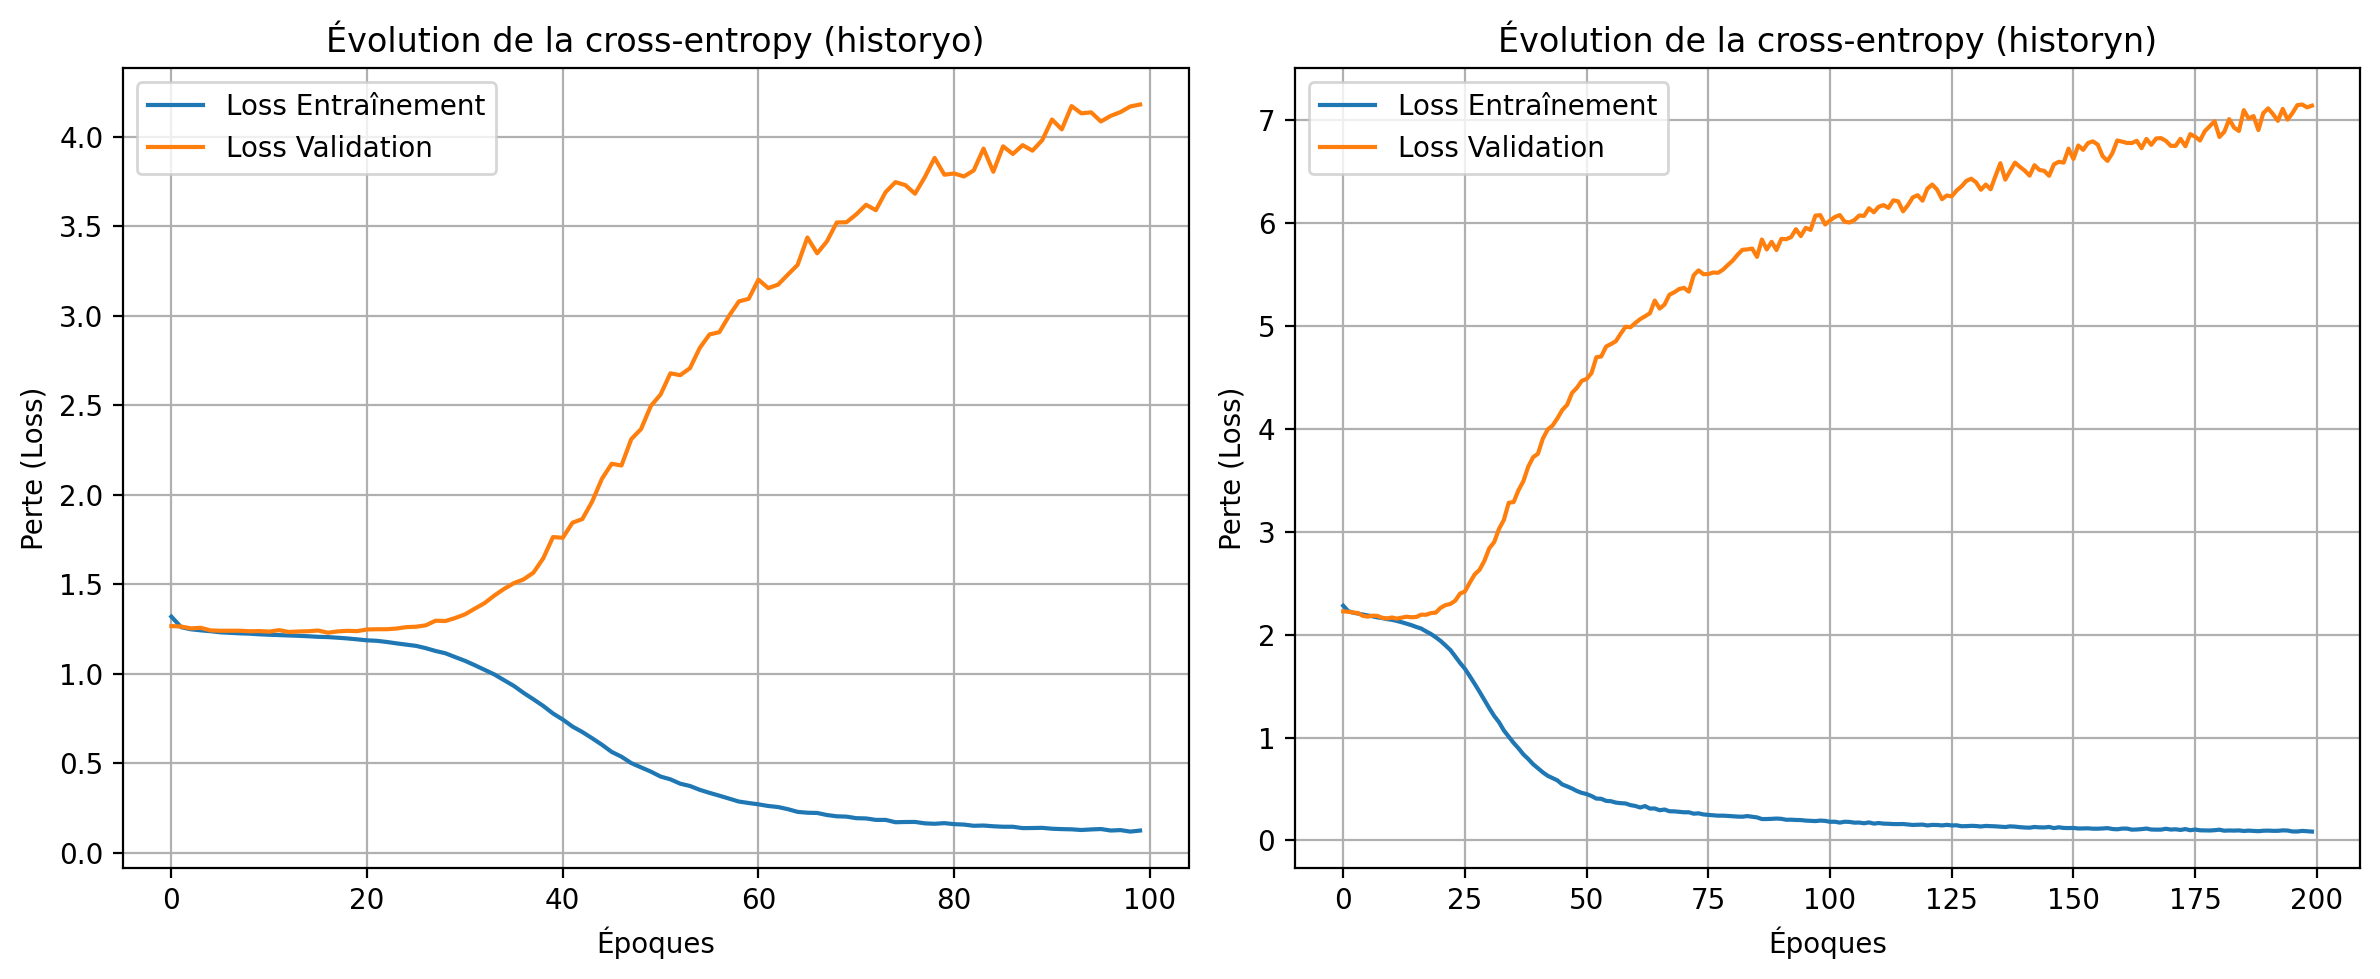

In [25]:
losso = historyo.history['loss']
val_losso = historyo.history['val_loss']

lossn = historyn.history['loss']
val_lossn = historyn.history['val_loss']


fig, axs = plt.subplots(1, 2, figsize=(12, 5))


axs[0].plot(losso, label='Loss Entraînement')
axs[0].plot(val_losso, label='Loss Validation')
axs[0].set_title('Évolution de la cross-entropy (historyo)')
axs[0].set_xlabel('Époques')
axs[0].set_ylabel('Perte (Loss)')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(lossn, label='Loss Entraînement')
axs[1].plot(val_lossn, label='Loss Validation')
axs[1].set_title('Évolution de la cross-entropy (historyn)')
axs[1].set_xlabel('Époques')
axs[1].set_ylabel('Perte (Loss)')
axs[1].legend()
axs[1].grid(True)


plt.tight_layout()
plt.show()

In [26]:
import joblib

joblib.dump(modelo, 'model_octave.pkl')
joblib.dump(modeln, 'model_note.pkl')

['model_note.pkl']

In [29]:
def generate_sequence_octave(seed_sequence, model=modelo, length=50, noise_std=0.0):
    '''fonction qui permet de générer une séquence de 100 notes après l'apprentissage du modèle '''
    generated = list(seed_sequence)

    for _ in range(length):
        
        input_seq_raw = generated[-50:]
        input_seq = to_categorical(input_seq_raw, num_classes=nb_octave).reshape(1, 50, nb_octave)

        # Prédiction
        pred_distribution = model.predict(input_seq, verbose=0)[0] 
        
        #Ajout de bruit
        if noise_std > 0.0:
            pred_distribution += np.random.normal(0, noise_std, size=pred_distribution.shape)
        
        #Note la plus probable
        next_val = int(np.argmax(pred_distribution))
        generated.append(next_val)

    return generated

def generate_sequence_note(seed_sequence, model=modeln, length=50, noise_std=0.0):
    '''fonction qui permet de générer une séquence de 100 notes après l'apprentissage du modèle '''
    generated = list(seed_sequence)

    for _ in range(length):
        
        input_seq_raw = generated[-50:]
        input_seq = to_categorical(input_seq_raw, num_classes=nb_note).reshape(1, 50, nb_note)

        # Prédiction
        pred_distribution = model.predict(input_seq, verbose=0)[0] 
        
        #Ajout de bruit
        if noise_std > 0.0:
            pred_distribution += np.random.normal(0, noise_std, size=pred_distribution.shape)
        
        #Note la plus probable
        next_val = int(np.argmax(pred_distribution))
        generated.append(next_val)

    return generated



ligne_seed = random.randint(0,df_test.shape[0]-1) #Choix aléatoire de la seed dans l'ensemble de test
seed_sequence_octave = dfo_test.iloc[ligne_seed, :50].astype(int).tolist()
seed_sequence_note = dfn_test.iloc[ligne_seed, :50].astype(int).tolist()

generated_octave = generate_sequence_octave(seed_sequence=seed_sequence_octave,model=modelo, length=100, noise_std=2.0)
generated_note = generate_sequence_note(seed_sequence=seed_sequence_note,model=modeln, length=100, noise_std=2.0)

In [31]:
def generate_music(generated_octave,generated_note):
    generated_music = []
    for i in range(len(generated_octave)):
        o,n = generated_octave[i],generated_note[i]
        generated_music.append(o*12+n)
    return generated_music

generated_music = generate_music(generated_octave,generated_note)


In [33]:
#Affichage du résultat non applati
s = stream.Stream()
duration = 0.5  # durée en quarts de note pour les notes générées

for e in generated_music:
    e = note.Note(e)
    e.quarterLength = duration
    s.append(e)

s.show('midi')

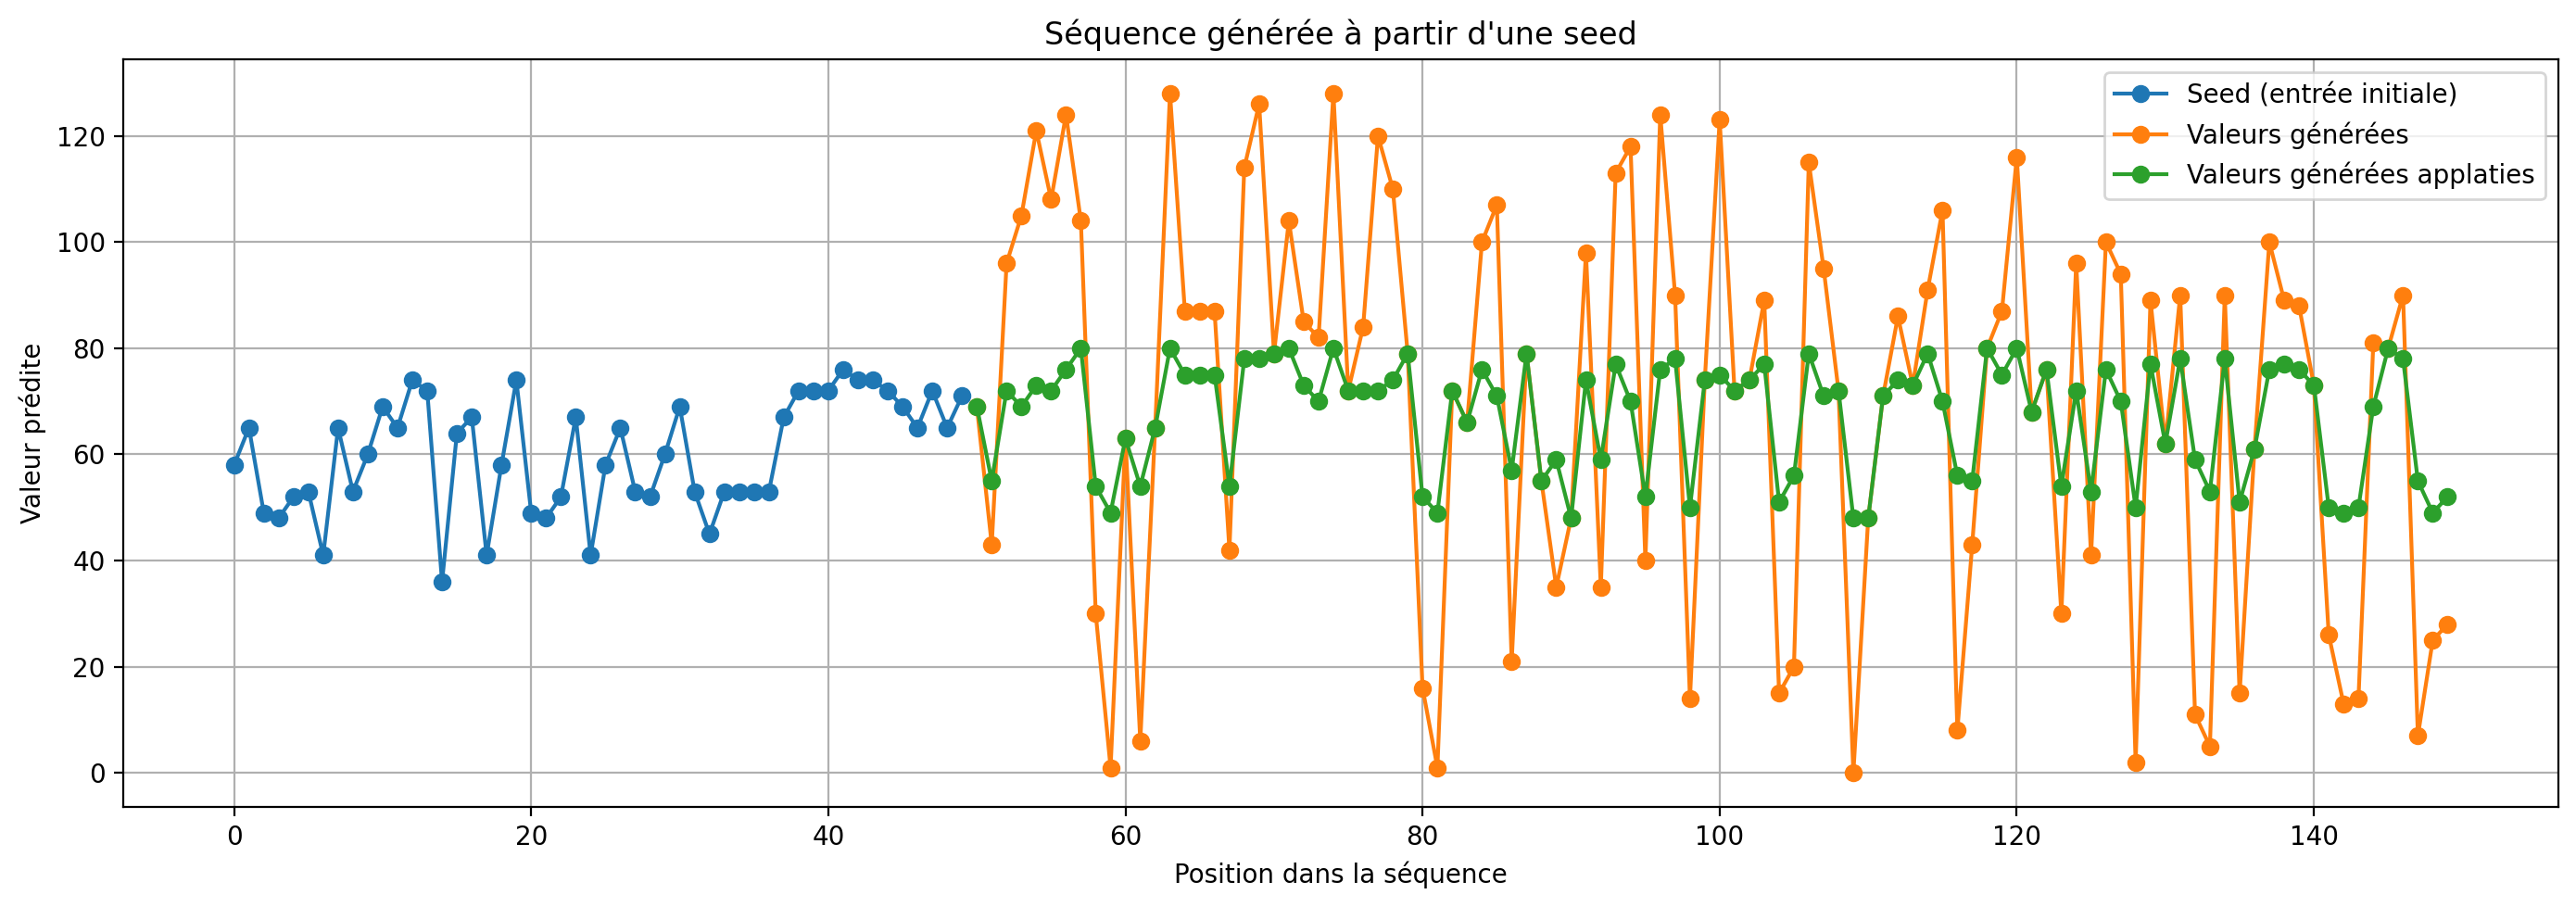

In [35]:
seed_sequence = generate_music(seed_sequence_octave,seed_sequence_note)

def applatissement(generated):
    ''' fonction qui permet "d'applatir" les notes à des 
    octaves plus raisonnables sans changer les notes pour 
    mieux rendre à l'oreille '''
    generated2 = []
    for k in range(len(generated)):
        n = generated[k]
        if k == 0:
            generated2.append(n)
        else:
            while n < 48: #note minimale pour une mélodie
                n+=12 #un octave en plus
            while n > 80: #note max mélodie
                n-=12 #un octave en moins
            generated2.append(n)
    return generated2

generated2 = applatissement(generated_music)



#Visualisation de la génération
plt.figure(figsize=(14, 5))
plt.plot(range(len(seed_sequence)), seed_sequence, label='Seed (entrée initiale)', marker='o')
plt.plot(range(len(seed_sequence), len(generated_music)), generated_music[len(seed_sequence):], label='Valeurs générées', marker='o')
plt.plot(range(len(seed_sequence), len(generated2)), generated2[len(seed_sequence):], label='Valeurs générées applaties', marker='o')
plt.title("Séquence générée à partir d'une seed")
plt.xlabel("Position dans la séquence")
plt.ylabel("Valeur prédite")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
#Affichage du résultat non applati
s = stream.Stream()
duration = 0.5  # durée en quarts de note pour les notes générées

for e in generated2:
    e = note.Note(e)
    e.quarterLength = duration
    s.append(e)

s.show('midi')